# Initial Model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import arviz as az

from cmdstanpy import cmdstan_path, CmdStanModel

In [2]:
%run utils.py

In [3]:
PROJECT_DIR = "/home/george/parts/"
print(cmdstan_path())

/home/george/.cmdstanpy/cmdstan-2.21.0


## Data

Let's just focus on Analysis II for now. Algebra looks like a completely different data set.

In [4]:
df = pd.read_csv(os.path.join(PROJECT_DIR, "data", "tidy", "parts.csv"))

In [5]:
class_name = "analysis.ii"

friday_mask = (df.loc[:, "class"] == "analysis.ii") & (df.loc[:, "day"] == "fri")
friday_data = df[friday_mask].loc[:, "parts"].dropna().values
non_friday_data = df[~friday_mask].loc[:, "parts"].dropna().values
N = non_friday_data.size
M = friday_data.size

## Examine Prior Predictive Distribution

Looking at the data, we can see what more than 40 parts per hour would be unusual, so we want to keep most of the mass less that $40$. Seeing as $lambda + 3 \sqrt{\lambda} = 40 \implies \lambda = 25 $, we would want to keep
$\lambda \leq 25$. If we place the prior $\lambda \sim \text{HalfNormal}(0, \sigma)$, and supposing we want to keep 99% of the probability mass below $25$, we would need to set $\sigma = 9.705$, as $$2\int_{0}^{25}{\frac{1}{9.705 \sqrt{2\pi}} \exp(\frac{-x^2}{2 \cdot 9.705^2}) dx} \approx 0.99$$.

So let's say $\lambda \sim \text{HalfNormal}(0, 10)$.

In [6]:
data = {
    "N": 100  # Number of samples
}

model, fit = run_stan_model(
    stan_file=os.path.join(PROJECT_DIR, "models", "_00-initial-prior_pred.stan"),
    data=data,
    fixed_param=True,
)

"""
cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    prior_predictive=["prior_pred_non_friday_parts", "prior_pred_friday_parts"],
    coords={'sample': np.arange(data["N"])},
    dims={
        "prior_pred_non_friday_parts": ["sample"],
        "prior_pred_friday_parts": ["sample"]
    }
)
""";

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /home/george/parts/models/_00-initial-prior_pred
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


We need to use a Betancourt plot, since plotting the density will confuse the _distribution_ of parts (which is what we care about) with the _predicted number_ of parts (which is what `az.plot_density` would show).

In [7]:
prior_pred_non_friday_parts = fit.get_drawset(["prior_pred_non_friday_parts"])
prior_pred_friday_parts = fit.get_drawset(["prior_pred_friday_parts"])

In [8]:
bins = np.arange(100)

non_friday_data_hist = np.histogram(non_friday_data, bins)[0]
friday_data_hist = np.histogram(friday_data, bins)[0]
non_friday_prior_pred_hist = np.vstack([np.histogram(row, bins=bins)[0] for row in prior_pred_non_friday_parts.values])
friday_prior_pred_hist = np.vstack([np.histogram(row, bins=bins)[0] for row in prior_pred_friday_parts.values])

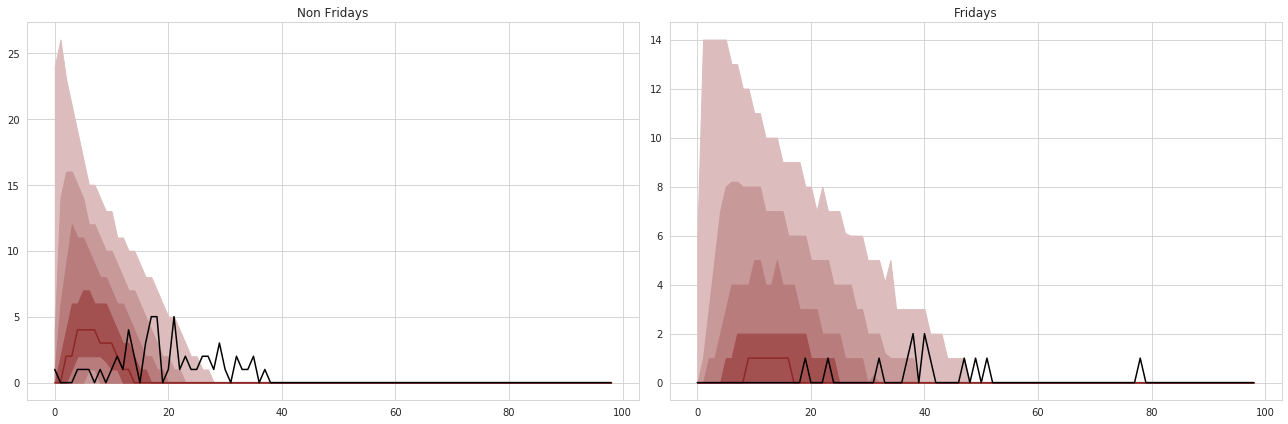

In [9]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=[18, 6])
plot_percentiles(non_friday_prior_pred_hist, title="Non Fridays", ax=axarr[0])
axarr[0].plot(non_friday_data_hist, color="black")

plot_percentiles(friday_prior_pred_hist, title="Fridays", ax=axarr[1])
axarr[1].plot(friday_data_hist, color="black")

plt.tight_layout()

## Fit Model

In [23]:
data = {
    "N": non_friday_data.shape[0],
    "M": friday_data.shape[0],
    "non_friday_parts": non_friday_data.astype(int),
    "friday_parts": friday_data.astype(int),
}

model, fit = run_stan_model(
    stan_file=os.path.join(PROJECT_DIR, "models", "_00-initial.stan"),
    data=data,
)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/george/parts/models/_00-initial
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


All diagnostics green!